In [1]:

import sys
sys.path.append("..")

import rasterio as rio
import os
import geopandas as gpd
from skimage.morphology import dilation, disk

import matplotlib.pyplot as plt


from visualization import fdi
from skimage.filters import threshold_otsu

from data.utils import split_line_gdf_into_segments, get_window, read_tif_image, remove_lines_outside_bounds

from skimage.morphology import dilation
from skimage.morphology import disk


In [2]:
import numpy as np
from skimage.segmentation import random_walker
from visualization import fdi, ndvi



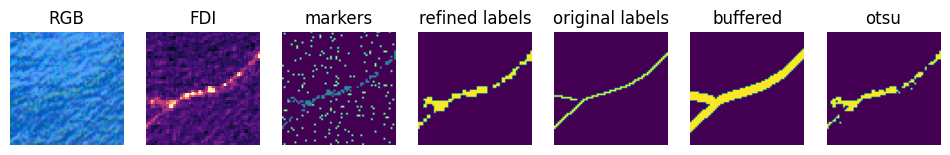

In [56]:
from rasterio import features
from data.label_refinement import refine_masks, refinement_args_list
from data.utils import get_window, read_tif_image, line_is_closed
from shapely.geometry import Polygon

root = "/ssd/marinedebris/floatingobjects/"
region = "accra_20181031" # accra_20181031
imagefile = os.path.join(root,f"{region}.tif")
shapefile = os.path.join(root,f"{region}.shp")



with rio.open(imagefile) as src:
    imagemeta = src.meta
    imagebounds = src.bounds
    

gdf = gpd.read_file(shapefile)

is_closed_line = gdf.geometry.apply(line_is_closed)
if is_closed_line.any():
    rasterize_polygons = gdf.loc[is_closed_line].geometry.apply(Polygon)
    gdf.loc[is_closed_line, "geometry"] = rasterize_polygons # replace
lines = gdf
    
lines = lines.to_crs(imagemeta["crs"])
#lines = split_line_gdf_into_segments(lines)
#lines = remove_lines_outside_bounds(lines, imagebounds)

output_size = 64
index = 15

line = lines.iloc[index]
window = get_window(line, output_size=output_size, transform=imagemeta["transform"])
image, win_transform = read_tif_image(imagefile, window)

mask = features.rasterize(lines.geometry, all_touched=True,
                              transform=win_transform, out_shape=image.shape[1:]) > 0

labels, otsu_segments, markers, fdi_image, mask_lines = refine_masks(image, mask,
                     buffersize_water=2,
                     water_seed_probability=0.95,
                     object_seed_probability=0.5,
                     rw_beta=10,
                    return_all=True)

from skimage.exposure import equalize_hist
rgb = equalize_hist(image[np.array([3,2,1])])

fig, axs = plt.subplots(1,7, figsize=(12,6))

axs[0].imshow(rgb.transpose(1,2,0))
axs[1].imshow(fdi_image, cmap="magma", vmin=0, vmax=128, interpolation="none")
axs[2].imshow(markers)
axs[3].imshow(labels==1)
axs[4].imshow(mask)
axs[5].imshow(mask_lines)
axs[6].imshow(otsu_segments)

for ax, title in zip(axs,["RGB", "FDI", "markers", "refined labels", "original labels","buffered", "otsu"]):
    ax.axis("off")
    ax.set_title(title)

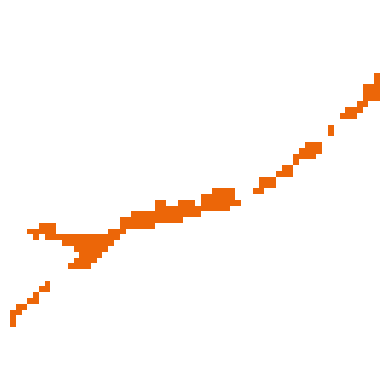

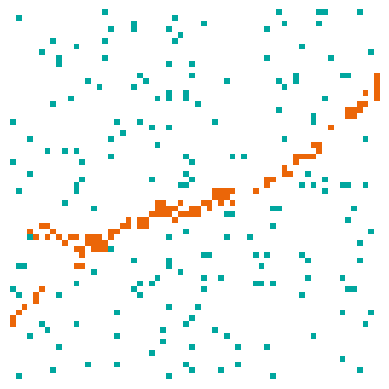

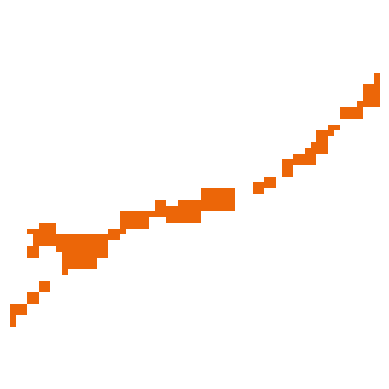

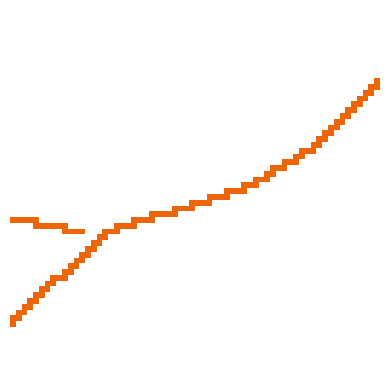

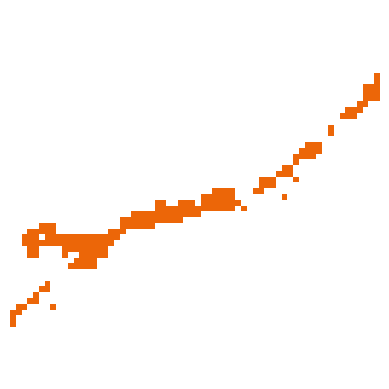

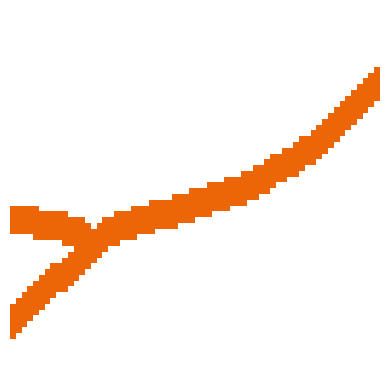

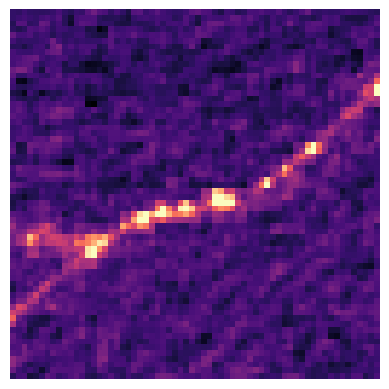

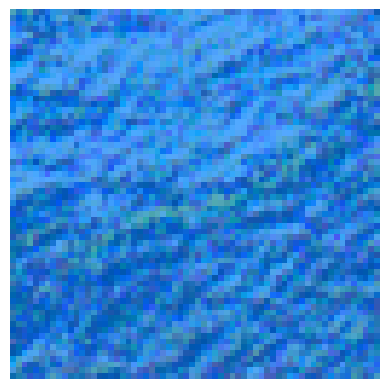

In [57]:
import matplotlib
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("markers", ["#ffffff","#EC6608","#00A79F"])
cmap2 = matplotlib.colors.LinearSegmentedColormap.from_list("markers", ["#ffffff","#EC6608"])

fig, ax = plt.subplots()
ax.imshow(otsu_segments * mask_lines,interpolation="none", cmap=cmap2)
ax.axis("off")
fig.savefig("/home/marc/Desktop/label_refinement/otsu_buffer.png", pad_inches=0, bbox_inches="tight")


fig, ax = plt.subplots()
ax.imshow(markers,interpolation="none", cmap=cmap)
ax.axis("off")
fig.savefig("/home/marc/Desktop/label_refinement/markers.png", pad_inches=0, bbox_inches="tight")

fig, ax = plt.subplots()
ax.imshow(labels==1,interpolation="none", cmap=cmap2)
ax.axis("off")
fig.savefig("/home/marc/Desktop/label_refinement/labels.png", pad_inches=0, bbox_inches="tight")

fig, ax = plt.subplots()
ax.imshow(mask, cmap=cmap2,interpolation="none")
ax.axis("off")
fig.savefig("/home/marc/Desktop/label_refinement/mask.png", pad_inches=0, bbox_inches="tight")

fig, ax = plt.subplots()
ax.imshow(otsu_segments, cmap=cmap2, interpolation="none")
ax.axis("off")
fig.savefig("/home/marc/Desktop/label_refinement/otsu_segments.png", pad_inches=0, bbox_inches="tight")

fig, ax = plt.subplots()
ax.imshow(mask_lines, cmap=cmap2 ,interpolation="none")
ax.axis("off")
fig.savefig("/home/marc/Desktop/label_refinement/mask_lines.png", pad_inches=0, bbox_inches="tight")

fig, ax = plt.subplots()
ax.imshow(fdi_image, cmap="magma", vmin=0, vmax=128, interpolation="none")
ax.axis("off")
fig.savefig("/home/marc/Desktop/label_refinement/fdi.png", pad_inches=0, bbox_inches="tight")

fig, ax = plt.subplots()
ax.imshow(rgb.transpose(1,2,0), interpolation="none")
ax.axis("off")
fig.savefig("/home/marc/Desktop/label_refinement/rgb.png", pad_inches=0, bbox_inches="tight")

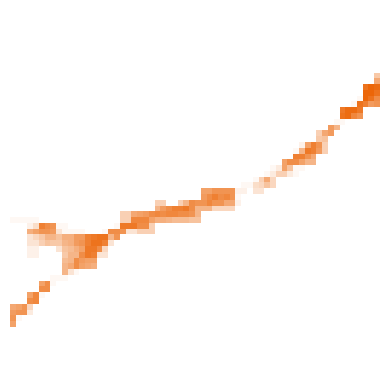

In [59]:

labels = [refine_masks(image, mask, **param) for param in refinement_args_list]
labels = [mask] + labels

masks = np.stack(labels)

summed_mask = masks.sum(0)
fig, ax = plt.subplots()
ax.imshow(summed_mask, cmap=cmap2, interpolation=None)
ax.axis("off")
fig.savefig("/home/marc/Desktop/label_refinement/masks_sum.png", pad_inches=0, bbox_inches="tight")

/tmp/ipykernel_25572/3846385870.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


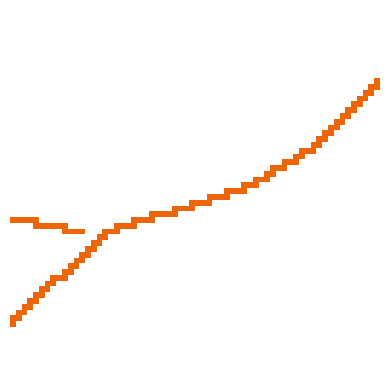

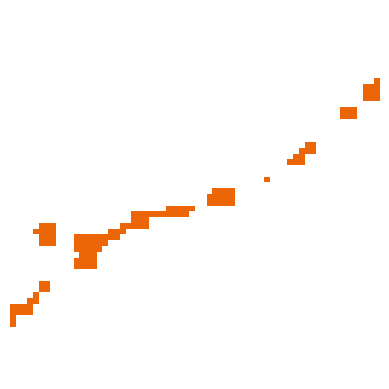

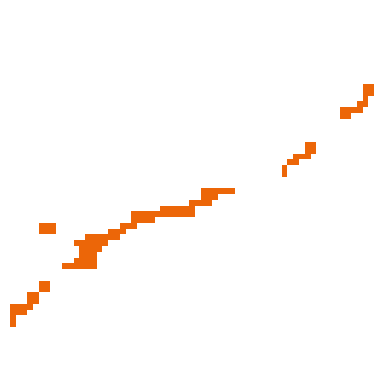

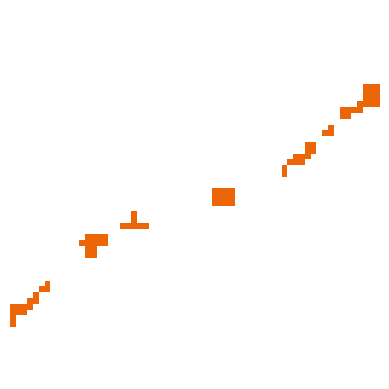

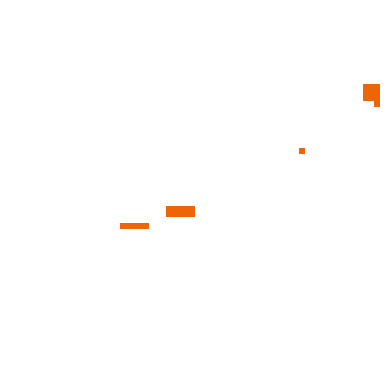

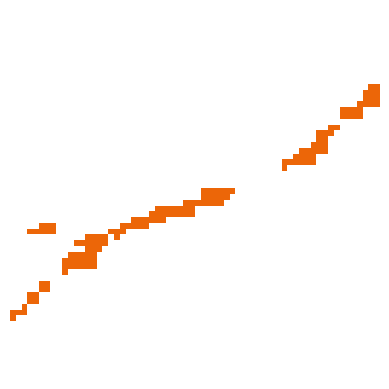

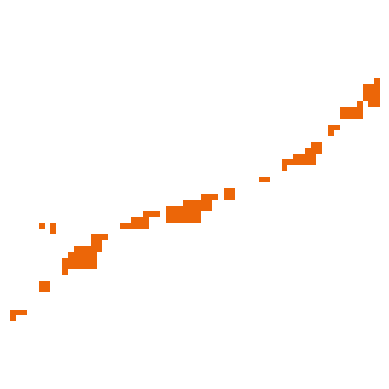

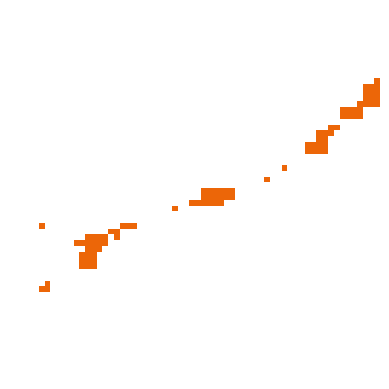

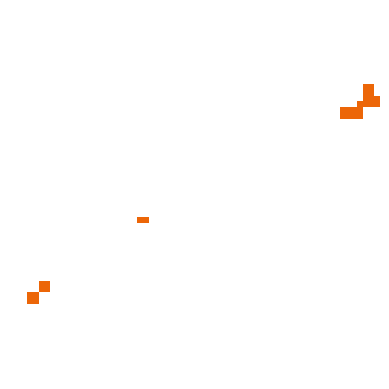

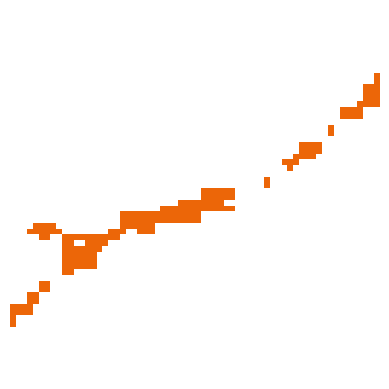

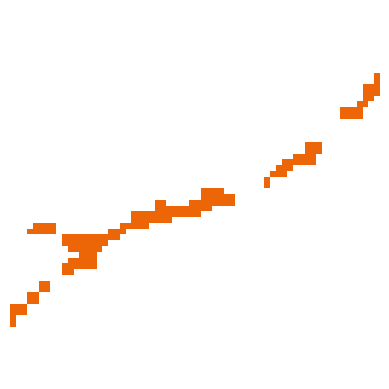

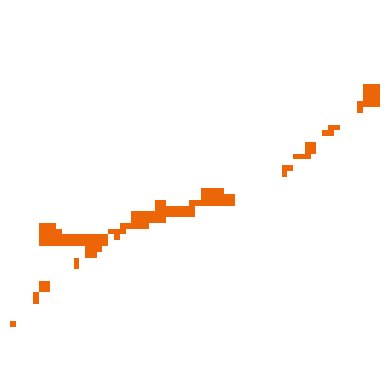

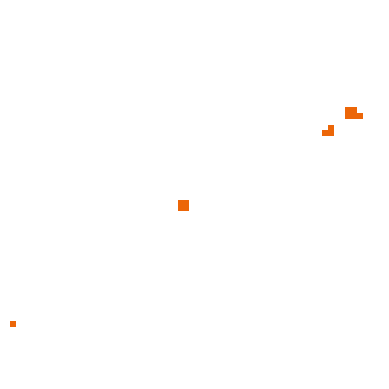

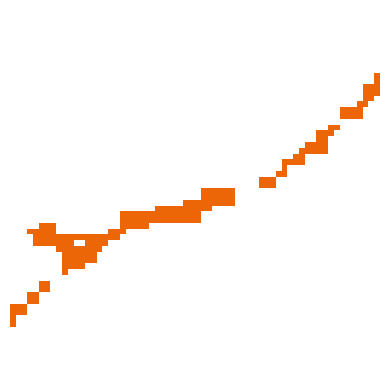

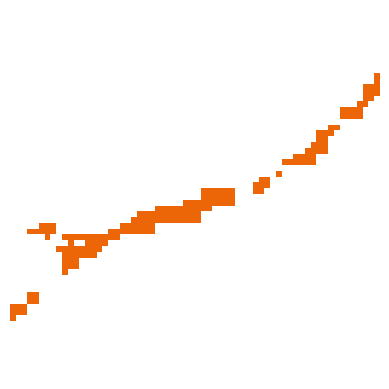

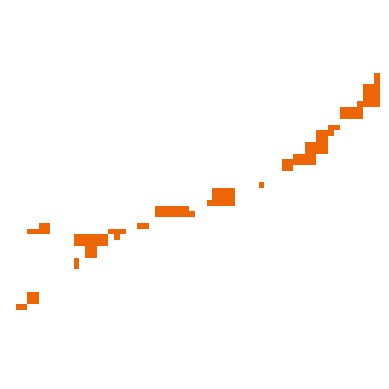

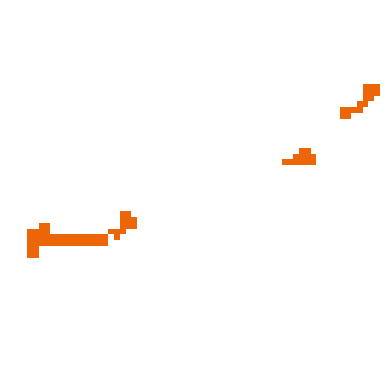

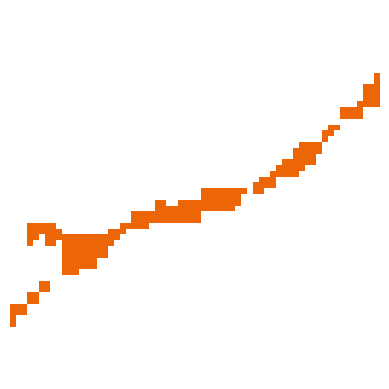

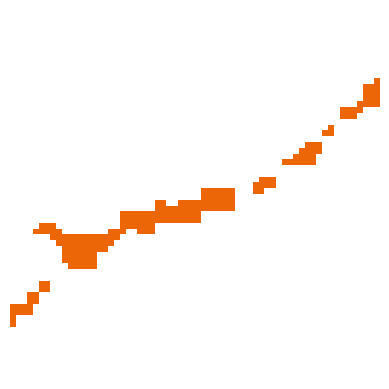

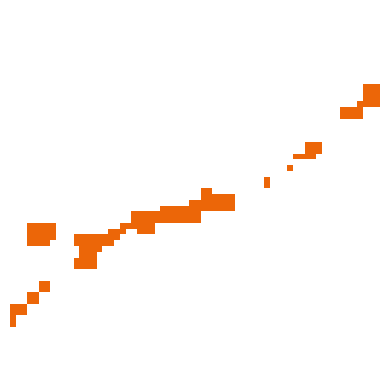

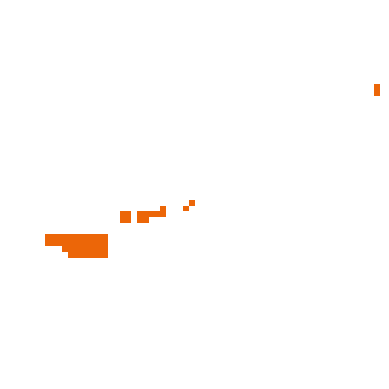

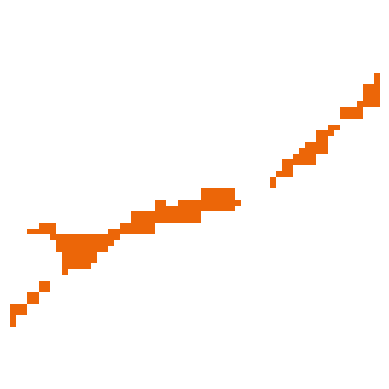

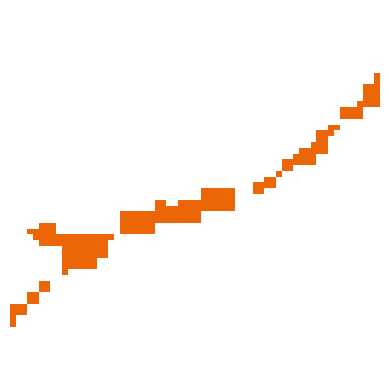

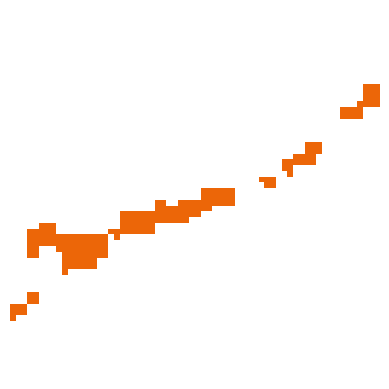

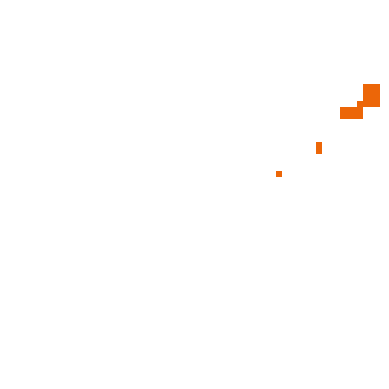

In [64]:
for i, mask in enumerate(masks):
    fig, ax = plt.subplots()
    ax.imshow(mask, cmap=cmap2, interpolation=None)
    ax.axis("off")
    fig.savefig(f"/home/marc/Desktop/label_refinement/masks{i}.png", pad_inches=0, bbox_inches="tight")

(-0.5, 63.5, 63.5, -0.5)

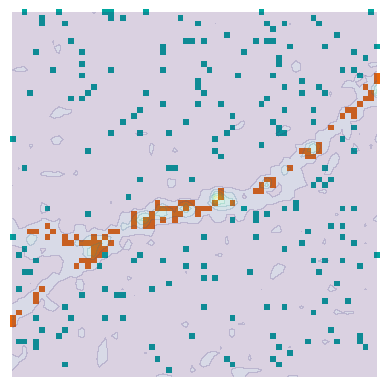

In [34]:
fig, ax = plt.subplots()
ax.imshow(markers,interpolation="none", cmap=cmap)
ax.contourf(fdi_image, alpha=0.2, levels=6)
ax.axis("off")

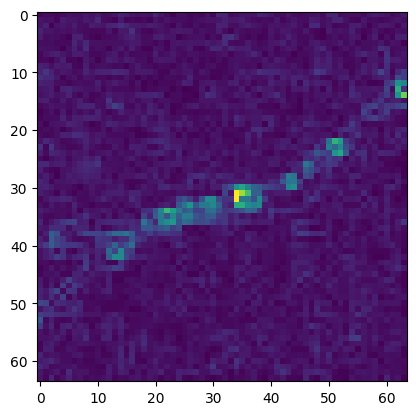

In [46]:
import skimage.filters
from skimage.filters import roberts, gaussian, sobel

plt.imshow(roberts(fdi_image))

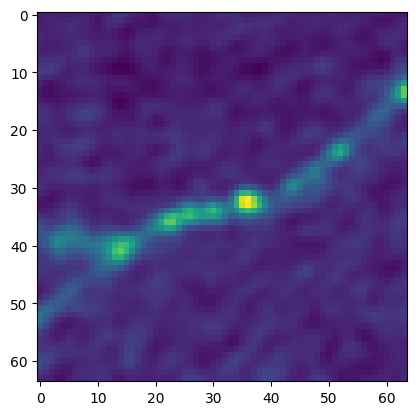

In [42]:
plt.imshow(gaussian(fdi_image))

In [306]:
labels.max()

1.0